### Kiểm định trên 1 hình ảnh mới không quen thuộc

In [17]:
# import thư viện
import pathlib
import subprocess
from dataclasses import dataclass
from typing import Literal, Optional, Tuple

import numpy as np
import PIL
import torch
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

In [18]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Lấy data

In [19]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))
    
    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)
    
    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    
    if title:
        plt.suptitle(title, fontsize=20)
            
    plt.tight_layout()

In [20]:
from example_data.wbc import WBCDataset

d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

n_support = 48

support_images, support_labels = zip(*itertools.islice(d_support, n_support))
support_images = torch.stack(support_images).to(device)
support_labels = torch.stack(support_labels).to(device)

In [21]:
support_images[0].shape

torch.Size([1, 128, 128])

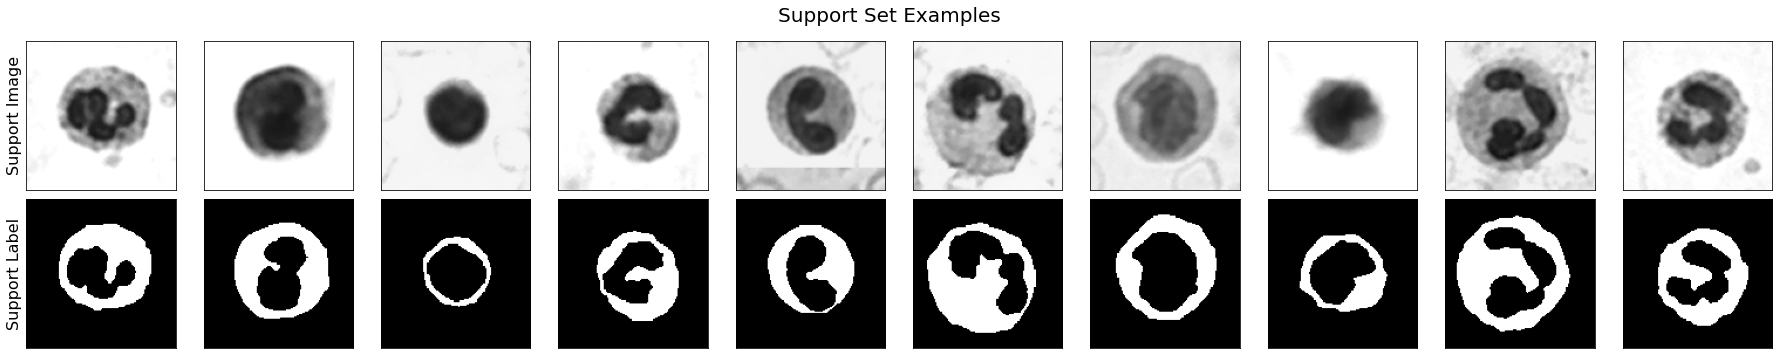

In [22]:
n_viz = 10
visualize_tensors({
    'Support Image': support_images[:n_viz],
    'Support Label': support_labels[:n_viz],
}, col_wrap=10, title='Support Set Examples')

*Note:*
- Tập data trên không có trong quá trình huấn luyện của univerSeg.
- Vì vậy, lấy thông số từ tập đã train và cho dự đoán tập hoàn toàn mới là wbc

### Dự đoán

In [23]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

torch.Size([1, 128, 128])
torch.Size([1, 128, 128])


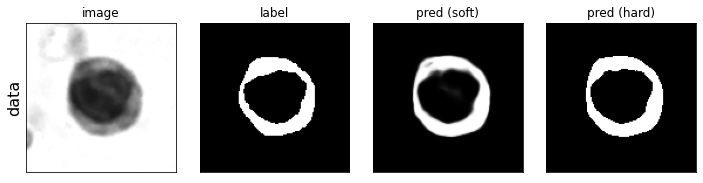

In [24]:
# select an image, label test pair
idx = np.random.permutation(len(d_test))[0]
image, label = d_test[idx]
image, label = image.to(device), label.to(device)
print(image.shape)
print(label.shape)
# run inference
logits = model(image[None], support_images[None], support_labels[None])[0].to('cpu')
pred = torch.sigmoid(logits)

# visualize
res = {'data': [image, label, pred, pred > 0.5]}
titles = col_names=['image', 'label', 'pred (soft)', 'pred (hard)']
visualize_tensors(res, col_wrap=4, col_names=titles)

In [25]:
print(logits.shape)
print(image.shape)

torch.Size([1, 128, 128])
torch.Size([1, 128, 128])


*Các bước lấy data và kiểm thử:*
- Lấy 1 bộ data hoàn toàn mới
- Chia 2 tập test và support
- support lấy ra labels và image
- Tính logits (vì input là ảnh 128x128 nên logit có size 128x128, yêu cầu tham số mô hình không thể thay đổi được)
- Với việc áp dụng hàm sigmoid, các giá trị đầu ra sẽ nằm trong khoảng từ 0 đến 1, và chúng có thể được xem như các xác suất ứng với mỗi pixel trong ảnh thu được từ mô hình segmentation.
- Ảnh pred(hard) chỉ gồm giá trị 0 hoặc 1 (đen và trắng) nên các pixel rõ ràng hơn

### Phân Tích Kết Quả Dự Đoán

Tiếp theo, chúng ta thực hiện dự đoán cho nhiều hình ảnh, tính toán các độ đo, và hiển thị kết quả.
Những thông tin này sẽ tạo nền tảng cho các phân tích sau đây về sự độ tin cậy của UniverSeg và cách hiệu suất của nó bị ảnh hưởng bởi sự lựa chọn của tập hỗ trợ.

In [26]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [29]:
# run inference and compute losses for one test image
@torch.no_grad() #Không cập nhật mô hình
def inference(model, image, label, support_images, support_labels):
    image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits        

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    # return a dictionary of all relevant variables
    return {'Image': image,
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

100%|██████████| 10/10 [01:00<00:00,  6.04s/it]


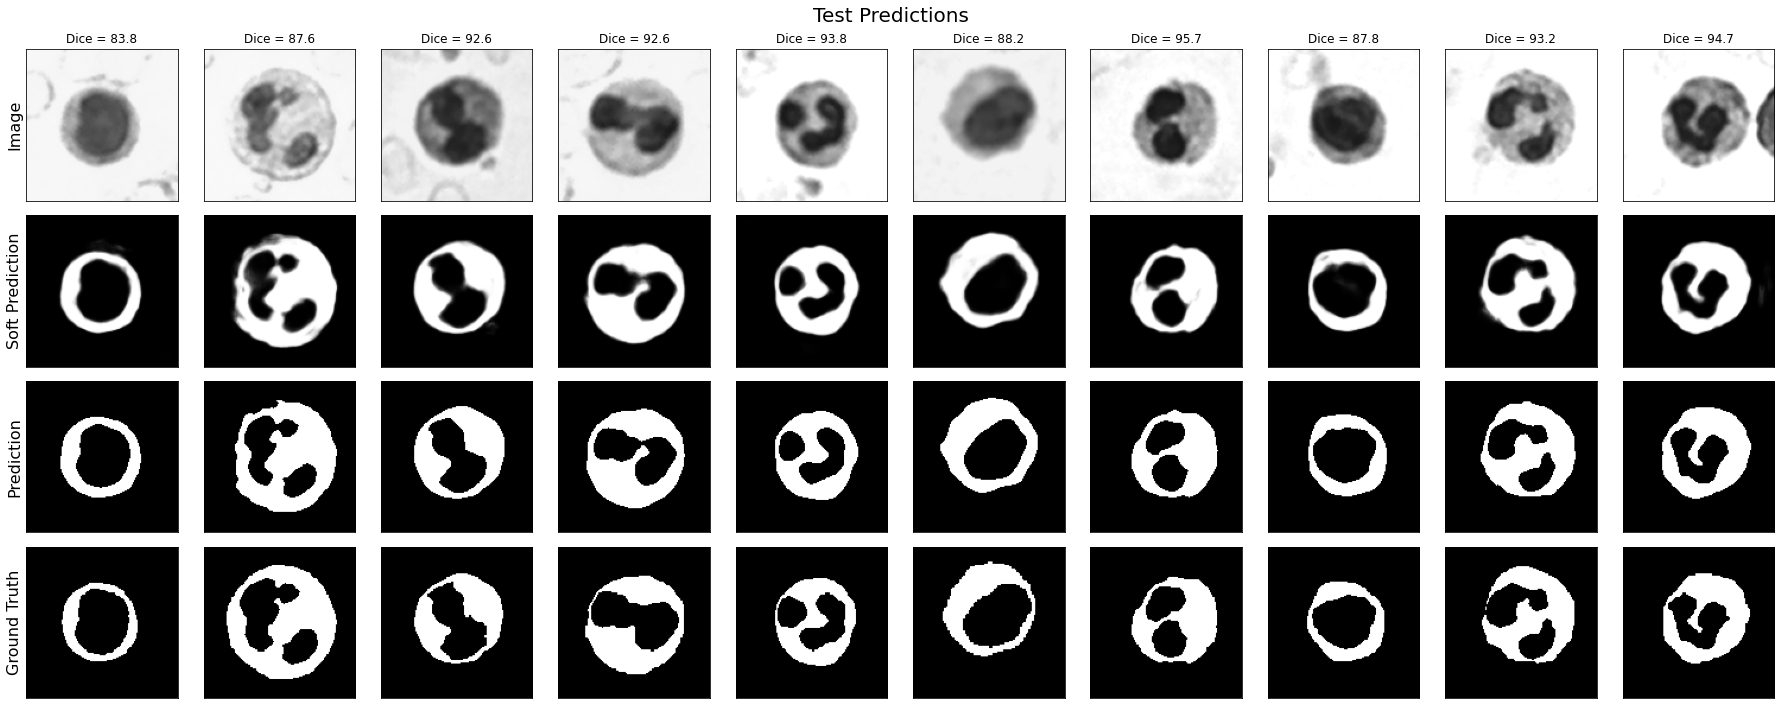

In [28]:
from collections import defaultdict

n_predictions = 10

results = defaultdict(list)

# compute inference and save predictions and metrics for n_predictions
idxs = np.random.permutation(len(d_test))[:n_predictions]

for i in tqdm(idxs):
    image, label = d_test[i]
    vals = inference(model, image, label, support_images, support_labels)
    for k, v in vals.items():
        results[k].append(v)
    
# visualize the results, along with their scores
scores = results.pop('score')    
visualize_tensors(results, 
                  col_names=[f'Dice = {100*s:.1f}' for s in scores], 
                  title='Test Predictions', 
                  col_wrap=n_predictions)

Việc số lượng ảnh trong tập support cải thiện độ chính xác của dự đoán, với dự đoán khá tốt cho N=4 hoặc N=8 đã, cho thấy rằng đối với một số bộ dữ liệu, UniverSeg có thể đạt được kết quả tuyệt vời ngay cả trong điều kiện dữ liệu thấp.

Tuy nhiên, UniverSeg có thể tận dụng các bộ dữ liệu lớn hơn và tiếp tục cải thiện. Chúng tôi phân tích điều này chi tiết trong bài báo.

*Note:*
- Ngoài ra, có thể test các dữ liệu của tập có nhãn khác nhau ví dụ wbc có 3 loại ảnh: "nucleus", "cytoplasm", "background". Models có thể dự đoán các nhãn khác nhau (chỉ cần đưa vào support thích hợp).

In [35]:
# helpful function to sample support data
def sample_support(seed):
    rng = np.random.default_rng(seed)
    idxs = rng.integers(0,len(d_support), size=support_size)
    support_images, support_labels = zip(*[d_support[i] for i in idxs])
    support_images = torch.stack(support_images).to(device)
    support_labels = torch.stack(support_labels).to(device)
    return support_images, support_labels

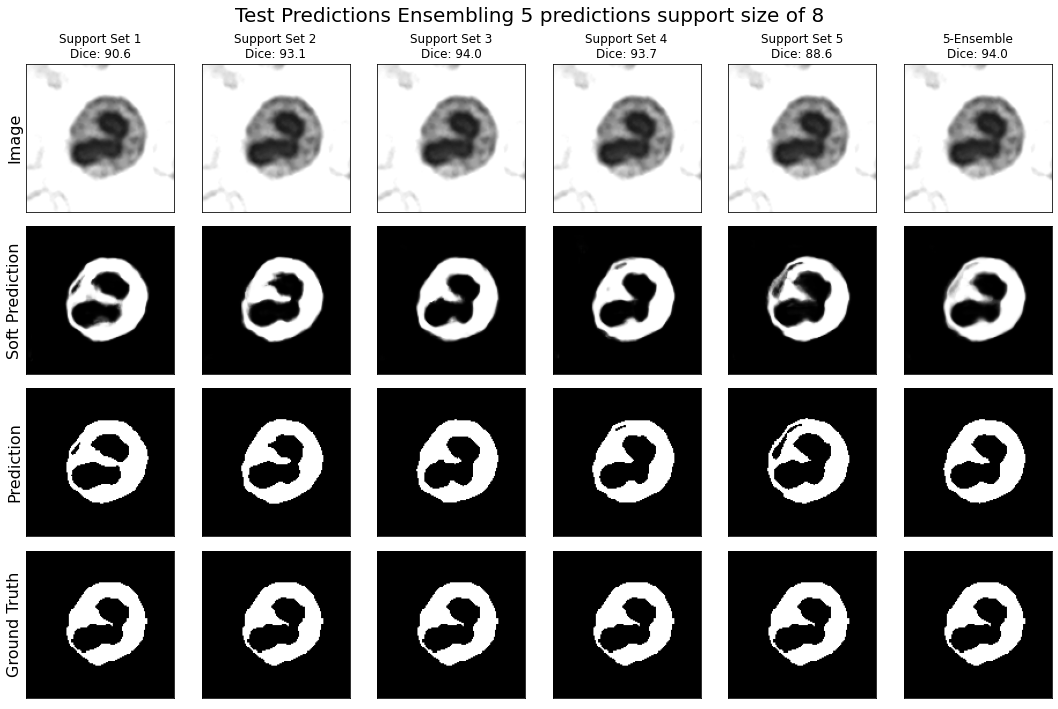

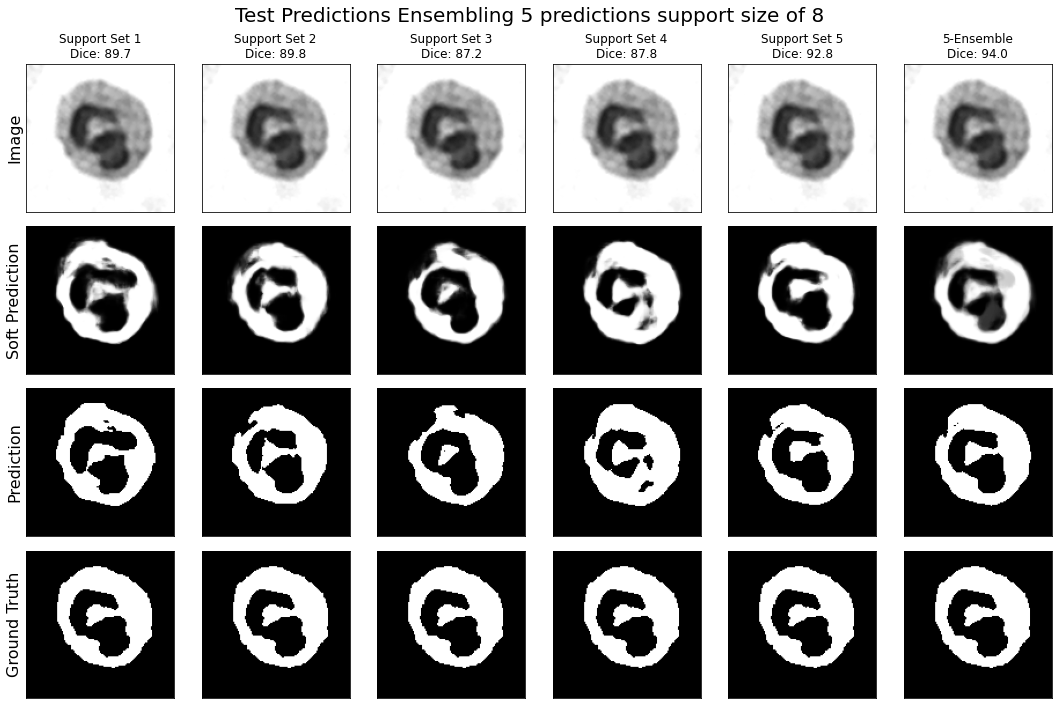

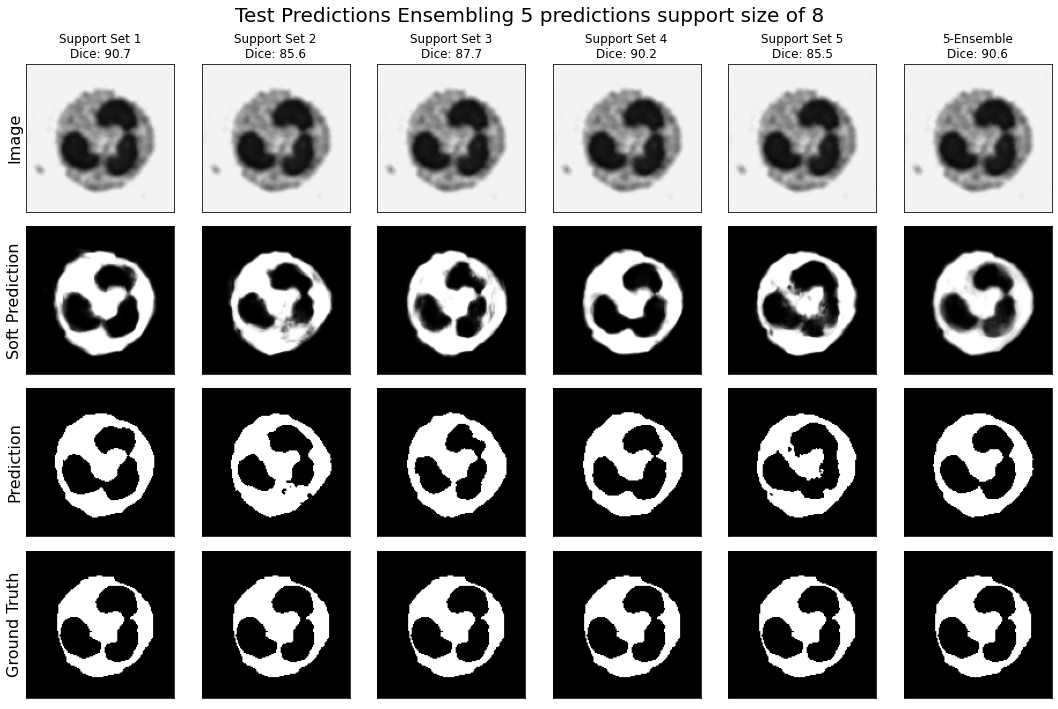

In [41]:
# get support data
d_support = WBCDataset('JTSC', split='support', label='cytoplasm')
d_test = WBCDataset('JTSC', split='test', label='cytoplasm')

# setup the number of predictions and ensembling 
support_size = 8
n_predictions = 3
n_ensemble = 5

# get various support sets
idxs = np.random.permutation(len(d_test))[:n_predictions]
# seeds = range(n_ensemble)
# supports = {
#     seed: sample_support(seed)
#     for seed in range(n_ensemble)
# }

# go through the number of experiments
for i in idxs:

    # go through the number of predictions we will ensemble
    results = defaultdict(list)
    for j in range(n_ensemble):
        # get support set and query
        support_images, support_labels = sample_support(j)
        image, label = d_test[i]

        # perform inference
        vals = inference(model, image, label, support_images, support_labels)
        for k, v in vals.items():
            results[k].append(v)
    
    results['Image'].append(image)
    ensemble = torch.mean(torch.stack(results['Soft Prediction']), dim=0)
    results['Soft Prediction'].append(ensemble)
    results['Prediction'].append(ensemble.round())
    results['Ground Truth'].append(label)
    results['score'].append(dice_score(ensemble.round(), label.to(device)))
    
    scores = results.pop('score')  
    col_names = [f'Support Set {i+1}' for i in range(n_ensemble)] + [f'{n_ensemble}-Ensemble']
    col_names = [col+f'\nDice: {100*score:.1f}' for col, score in zip(col_names, scores)]
    
    visualize_tensors(results, 
                      col_names=col_names, 
                      title=f'Test Predictions Ensembling {n_ensemble} predictions support size of {support_size}', 
                      col_wrap=n_ensemble+1)

*Note:*
- Tính trung bình 5 lần dự đoán với 5 tập support khác nhau sẽ cho ra kết quả tốt hơn (ensembling prediction)